# Intro 

This book uses the IB InSync library:  https://github.com/erdewit/ib_insync 

In [39]:
from ib_insync import *
import math
import pandas as pd
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 4001, clientId=1235)

<IB connected to 127.0.0.1:4001 clientId=1235>

In [40]:
spx = Index('SPX', 'CBOE')
ib.qualifyContracts(spx)

[Index(conId=416904, symbol='SPX', exchange='CBOE', currency='USD', localSymbol='SPX')]

In [49]:
import math
ib.reqMarketDataType(4)
[ticker] = ib.reqTickers(spx)
spxValue = ticker.marketPrice()


if math.isnan(spxValue):
    spxValue = 4470
    
spxValue

4470

In [42]:
chains = ib.reqSecDefOptParams(spx.symbol, '', spx.secType, spx.conId)
df_chains = util.df(chains)
df_chains

,exchange,underlyingConId,tradingClass,multiplier,expirations,strikes
0,SMART,416904,SPX,100,"[20210916, 20211014, 20211118, 20211216, 20220...","[100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700..."
1,CBOE,416904,SPXW,100,"[20210827, 20210830, 20210831, 20210901, 20210...","[100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700..."
2,SMART,416904,SPXW,100,"[20210827, 20210830, 20210831, 20210901, 20210...","[100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700..."
3,CBOE,416904,SPX,100,"[20210916, 20211014, 20211118, 20211216, 20220...","[100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700..."


In [50]:
chain = next(c for c in chains if c.tradingClass == 'SPX' and c.exchange == 'CBOE')
chain

OptionChain(exchange='SMART', underlyingConId='416904', tradingClass='SPX', multiplier='100', expirations=['20210916', '20211014', '20211118', '20211216', '20220120', '20220217', '20220317', '20220413', '20220519', '20220616', '20220714', '20220818', '20220915', '20221215', '20230119', '20230615', '20231214'], strikes=[100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1150.0, 1200.0, 1225.0, 1250.0, 1275.0, 1300.0, 1325.0, 1350.0, 1375.0, 1400.0, 1425.0, 1450.0, 1475.0, 1500.0, 1525.0, 1550.0, 1575.0, 1600.0, 1625.0, 1650.0, 1675.0, 1700.0, 1725.0, 1750.0, 1775.0, 1800.0, 1825.0, 1850.0, 1875.0, 1900.0, 1925.0, 1950.0, 1975.0, 2000.0, 2025.0, 2050.0, 2075.0, 2100.0, 2125.0, 2150.0, 2175.0, 2200.0, 2225.0, 2250.0, 2275.0, 2300.0, 2325.0, 2350.0, 2375.0, 2400.0, 2425.0, 2450.0, 2475.0, 2500.0, 2525.0, 2550.0, 2575.0, 2600.0, 2625.0, 2650.0, 2675.0, 2700.0, 2725.0, 2740.0, 2750.0, 2760.0, 2770.0, 2775.0, 2780.0, 2790.0, 2800.0, 2810.0, 2820.0, 2825.0, 2830.0, 

In [82]:
strikes = [strike for strike in chain.strikes
        if strike % 5 == 0
        and spxValue - 200 < strike < spxValue + 200]
expirations = sorted(exp for exp in chain.expirations)[:3]
rights = ['P', 'C']

contracts = [Option('SPX', expiration, strike, right, 'SMART', tradingClass='SPX')
        for right in rights
        for expiration in expirations
        for strike in strikes]

contracts = ib.qualifyContracts(*contracts)
print(f'There are {len(contracts)} valid contracts')

Error 200, reqId 519: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20211118', strike=4295.0, right='P', exchange='SMART', tradingClass='SPX')
Error 200, reqId 521: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20211118', strike=4305.0, right='P', exchange='SMART', tradingClass='SPX')
Error 200, reqId 517: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20211118', strike=4285.0, right='P', exchange='SMART', tradingClass='SPX')
Error 200, reqId 523: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20211118', strike=4315.0, right='P', exchange='SMART', tradingClass='SPX')
Error 200, reqId 527: No security definition has been found for the request, contract: Option(symbol='SPX', lastTradeDateOrContractMonth='20211118',

There are 410 valid contracts


In [83]:
tickers = ib.reqTickers(*contracts)

Error 10090, reqId 831: Part of requested market data is not subscribed. Subscription-independent ticks are still active.Delayed market data is available.SPX S&P 500 Stock Index/TOP/ALL, contract: Option(conId=462826696, symbol='SPX', lastTradeDateOrContractMonth='20210916', strike=4275.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPX   210917P04275000', tradingClass='SPX')
Error 10090, reqId 832: Part of requested market data is not subscribed. Subscription-independent ticks are still active.Delayed market data is available.SPX S&P 500 Stock Index/TOP/ALL, contract: Option(conId=478322973, symbol='SPX', lastTradeDateOrContractMonth='20210916', strike=4280.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPX   210917P04280000', tradingClass='SPX')
Error 10090, reqId 833: Part of requested market data is not subscribed. Subscription-independent ticks are still active.Delayed market data is available.SPX S&P 500 Stock Index/

In [85]:
import pandas as pd
imp_vol_df = pd.DataFrame(columns=['strike', 'expiration', 'right', 'imp_vol'])
for t in tickers: 
    print(t)
    try:
        imp_vol_df = imp_vol_df.append({'strike':t.contract.strike, 'expiration':t.contract.lastTradeDateOrContractMonth, 'right':t.contract.right, 'imp_vol':(t.bidGreeks.impliedVol + t.askGreeks.impliedVol)/2.0}, ignore_index=True)
    except:
        print('Ignorable error for now.')

Ticker(contract=Option(conId=462826696, symbol='SPX', lastTradeDateOrContractMonth='20210916', strike=4275.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPX   210917P04275000', tradingClass='SPX'), time=datetime.datetime(2021, 8, 27, 14, 28, 57, 28435, tzinfo=datetime.timezone.utc), bidGreeks=OptionComputation(impliedVol=0.19033172905343468, delta=None, optPrice=None, pvDividend=4.29471701482645, gamma=None, vega=None, theta=None, undPrice=4498.96), askGreeks=OptionComputation(impliedVol=0.19166024828366882, delta=None, optPrice=None, pvDividend=4.29471701482645, gamma=None, vega=None, theta=None, undPrice=4498.96), lastGreeks=OptionComputation(impliedVol=None, delta=None, optPrice=None, pvDividend=4.29471701482645, gamma=None, vega=None, theta=None, undPrice=4498.96), modelGreeks=OptionComputation(impliedVol=0.19118801818952244, delta=-0.13330150329296653, optPrice=14.217232454916882, pvDividend=4.29471701482645, gamma=0.0010374976374045192, vega=2.335

In [86]:
imp_vol_df

,strike,expiration,right,imp_vol
0,4275.0,20210916,P,0.190996
1,4280.0,20210916,P,0.189203
2,4285.0,20210916,P,0.187367
3,4290.0,20210916,P,0.185696
4,4295.0,20210916,P,0.183976
...,...,...,...,...
398,4625.0,20211118,C,0.121438
399,4630.0,20211118,C,0.120695
400,4640.0,20211118,C,0.119305
401,4650.0,20211118,C,0.118024


# Implied vola curve

/home/ustaudinger/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


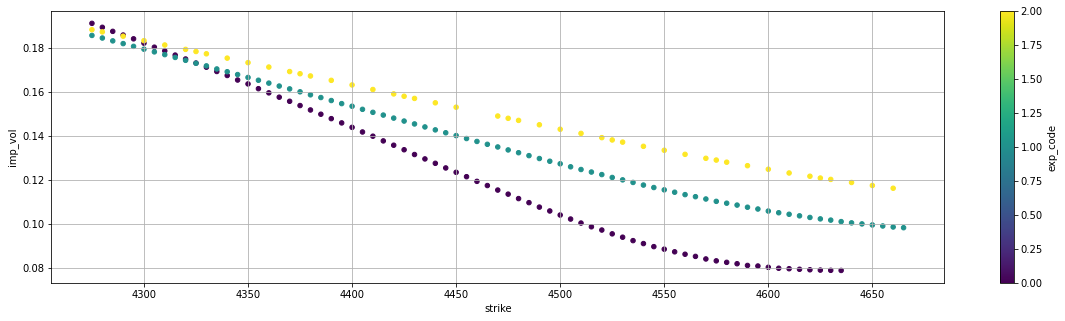

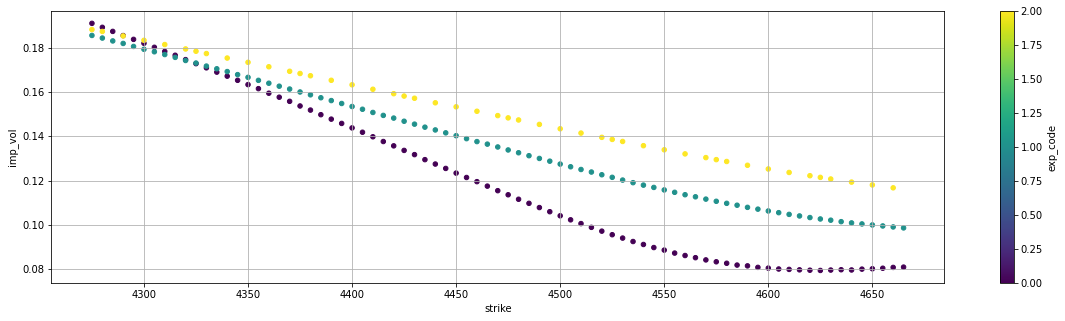

In [87]:
import matplotlib.pyplot as plt

imp_vol_df.expiration = pd.Categorical(imp_vol_df.expiration)
imp_vol_df['exp_code'] = imp_vol_df.expiration.cat.codes

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'P'].plot.scatter(x='strike', y='imp_vol', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax).grid()

fig, ax = plt.subplots()
imp_vol_df[imp_vol_df.right == 'C'].plot.scatter(x='strike', y='imp_vol', c='exp_code', cmap="viridis", figsize=(20,5), ax=ax).grid()

In [ ]:
ib.disconnect()